In this notebook, try to make global model work by augmenting trajectories with parameters values. Don't do encoder as it is an optional compression step which would be needed only if we were trying to work with high-dim data like images!

we also try a corrected `get_batch` procedure - see `get_batch2()` from `/Users/ajivani/ode_demo_2_true_bt` which adapts example from `torchdiffeq` but makes sure that for each "IC" in our batch from a trajectory, the time vector is correctly indexed instead of just starting from zero like they did in the library's `get_batch()` routine which seems to be clearly wrong!

we also do a "testing" run - where we take only 3 or 4 sims in turn, and run through multiple batches of each one by one to see how the network adapts or if it adapts to learn a general parametrized version of them in the first place. We can even track error across all 3 simulations in our log.

In [2]:
import pandas as pd

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
# import sparselinear as sl

In [5]:
adjoint=True

In [6]:
!pip install torchdiffeq

Defaulting to user installation because normal site-packages is not writeable


In [7]:
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [9]:
runModel=False
runTestCase=True

In [10]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt

In [11]:
import re
import os
import time

In [12]:
%matplotlib inline

In [13]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
plt.style.use("dark_background")

In [14]:
import edge_utils as edut

### Load Data, split into train and test

In [15]:
# we are removing some data where the edge detection is not necessarily super reliable.
sims_to_remove = np.array([33, 39, 63, 73, 113, 128, 131, 142, 193, 218, 253, 264, 273, 312, 313, 324])

In [16]:
ed_2161, sd_2161 = edut.load_edge_data_blobfree(2161)

In [17]:
theta_s_2161, theta_e_2161 = np.linspace(0, 360, 512)[160] + 1.2 * 180 - 360, np.linspace(0, 360, 512)[320] + 1.2 * 180 - 360
print("Range of angles for CR2161: {} {}".format(theta_s_2161, theta_e_2161))

Range of angles for CR2161: -31.279843444227026 81.44031311154595


In [18]:
nTimes, nTheta_2161, nSims_2161 = ed_2161.shape
nTimes, nTheta_2161, nSims_2161

(90, 160, 278)

In [19]:
theta_grid = np.linspace(np.ceil(theta_s_2161), np.ceil(theta_e_2161), nTheta_2161)

In [20]:
sd_modified = np.setdiff1d(sd_2161, sims_to_remove)

In [21]:
len(sd_modified)

262

In [22]:
# extract training and test sets. for now just random.

from numpy.random import Generator, PCG64
rng = Generator(PCG64())

nTrain = int(np.floor(0.8 * len(sd_modified)))
nTest = len(sd_modified) - nTrain

nTrain, nTest

(209, 53)

In [23]:
sd_train = np.sort(np.random.choice(sd_modified, nTrain, replace=False))
sd_test = np.setdiff1d(sd_modified, sd_train)
sd_test

array([ 40,  42,  44,  49,  56,  57,  66,  74,  81,  88,  91,  94,  95,
        97, 103, 114, 115, 123, 127, 136, 139, 141, 144, 148, 149, 151,
       152, 162, 164, 171, 179, 188, 190, 198, 202, 205, 209, 212, 216,
       219, 227, 241, 246, 251, 262, 293, 294, 296, 301, 302, 306, 325,
       329])

In [24]:
sd_test.shape

(53,)

In [25]:
def getRValuesAllSims(edge_data_matrix):
    """
    Return r values for all sims at once so we don't lose time in training processing r values repeatedly
    """
    r_data_matrix = np.zeros(edge_data_matrix.shape)
    nsims = edge_data_matrix.shape[2]
    for i in range(nsims):
        r_vals, theta_vals = edut.getRValues(edge_data_matrix, simIdx=i, minStartIdx=0)
        r_data_matrix[:, :, i] = r_vals

    return r_data_matrix

In [26]:
rd_2161 = getRValuesAllSims(ed_2161)

### Set up for Parametrized and Regular Neural ODEs

In [27]:
# get the param list for CR2161, get background values as well

In [28]:
cme_params = pd.read_csv("./restarts_CR2161.csv")
cme_params.head()

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,restartdir,realization
0,0.58375,22.526622,0.682075,204.725,1,4,4
1,0.52625,6.919483,0.519179,164.225,1,4,4
2,0.72625,5.087500,0.662022,233.975,1,4,4
3,0.36125,18.360770,0.420743,200.675,-1,4,4
4,0.69125,8.127120,0.735101,184.925,1,4,4


In [29]:
bg_params = pd.read_csv("./backgrounds_CR2161.csv")
bg_params

,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
0,0.5987,547686.9,259077.5
1,0.6876,514248.2,170240.5
2,0.7334,437169.7,242477.4
3,0.8010,378833.7,147856.5
4,0.9431,491082.5,205150.8
5,1.0077,349735.7,230084.9
6,1.0404,668772.0,278163.0
7,1.0921,463650.6,299730.0
8,1.2009,337215.4,113682.7
9,1.2292,583776.3,160912.2


In [30]:
unique_bg = cme_params.restartdir.unique()
unique_bg

array([ 4, 12])

In [31]:
bg_params.FactorB0[3]

0.801

In [32]:
bg_params.shape

(30, 3)

In [33]:
# identify which rows correspond to a particular background
cme_param_bg_idx = []
for bg in unique_bg:
    cme_param_bg_idx.append(np.array((cme_params.restartdir == bg).to_list()))

# now append columns to cme_params dataframe to merge

In [34]:
cme_params

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,restartdir,realization
0,0.58375,22.526622,0.682075,204.725,1,4,4
1,0.52625,6.919483,0.519179,164.225,1,4,4
2,0.72625,5.087500,0.662022,233.975,1,4,4
3,0.36125,18.360770,0.420743,200.675,-1,4,4
4,0.69125,8.127120,0.735101,184.925,1,4,4
...,...,...,...,...,...,...,...
295,0.36250,32.665259,0.436133,197.750,-1,12,5
296,0.46250,26.757500,0.443711,224.750,1,12,5
297,0.76250,16.930533,0.874492,215.750,-1,12,5
298,0.61250,21.948929,0.553164,188.750,1,12,5


In [35]:
bg_params_to_insert = np.zeros((cme_params.shape[0], bg_params.shape[1]))
for bg_idx, bg in enumerate(unique_bg):
    bg_params_to_insert[cme_param_bg_idx[bg_idx], 0] = bg_params.FactorB0[bg - 1]
    bg_params_to_insert[cme_param_bg_idx[bg_idx], 1] = bg_params.PoyntingFluxPerBSi[bg - 1]
    bg_params_to_insert[cme_param_bg_idx[bg_idx], 2] = bg_params.LperpTimesSqrtBSi[bg - 1]

cme_params["FactorB0"] = pd.Series(bg_params_to_insert[:, 0])
cme_params["PoyntingFluxPerBSi"] = pd.Series(bg_params_to_insert[:, 1])
cme_params["LperpTimesSqrtBSi"] = pd.Series(bg_params_to_insert[:, 2])
cme_params["SimID"] = pd.Series(np.linspace(31, 330, 300))
sim_idx_successful = sd_2161 - 30 - 1
sim_idx_to_drop = np.setdiff1d(np.linspace(0, 299, 300), sim_idx_successful).astype(int).tolist()

sim_idx_to_drop
cme_params.drop(["restartdir"], axis=1, inplace=True)
cme_params.drop(sim_idx_to_drop, inplace=True)
cme_params.drop(["SimID"], axis=1, inplace=True)
cme_params

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,realization,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
0,0.58375,22.526622,0.682075,204.725,1,4,0.8010,378833.7,147856.5
1,0.52625,6.919483,0.519179,164.225,1,4,0.8010,378833.7,147856.5
2,0.72625,5.087500,0.662022,233.975,1,4,0.8010,378833.7,147856.5
3,0.36125,18.360770,0.420743,200.675,-1,4,0.8010,378833.7,147856.5
4,0.69125,8.127120,0.735101,184.925,1,4,0.8010,378833.7,147856.5
...,...,...,...,...,...,...,...,...,...
294,0.73750,15.331483,0.721367,170.750,-1,5,1.3016,304514.4,283042.3
295,0.36250,32.665259,0.436133,197.750,-1,5,1.3016,304514.4,283042.3
296,0.46250,26.757500,0.443711,224.750,1,5,1.3016,304514.4,283042.3
297,0.76250,16.930533,0.874492,215.750,-1,5,1.3016,304514.4,283042.3


In [36]:
cme_params.ApexHeight.min(), cme_params.ApexHeight.max()

(0.280873828, 0.928935547)

In [37]:
0.875 * 0.3, 1.25 * 0.8

(0.2625, 1.0)

In [38]:
cme_params.BStrength.min(), cme_params.BStrength.max()

(5.0875, 42.76293137)

In [39]:
(0.5 / 0.8) * 19.25 * 0.37, (2.0 / 0.3) * 19.25 * 0.37

(4.4515625, 47.483333333333334)

In [40]:
cme_params.OrientationCme.min(), cme_params.OrientationCme.max()

(155.225, 244.775)

In [41]:
200 - 45, 200 + 45

(155, 245)

In [42]:
type(cme_params.min())
# cme_params.max()

pandas.core.series.Series

In [43]:
cme_p_min = cme_params.min()
cme_p_min.BStrength = 4.4516
cme_p_min.Radius = 0.3
cme_p_min.OrientationCme = 155
cme_p_min.iHelicity = -1
cme_p_min.ApexHeight = 0.2625
cme_p_min.realization = 1
cme_p_min.FactorB0 = 0.54
cme_p_min.PoyntingFluxPerBSi = 0.3e6
cme_p_min.LperpTimesSqrtBSi = 0.3e5

cme_p_min

Radius                     0.3000
BStrength                  4.4516
ApexHeight                 0.2625
OrientationCme           155.0000
iHelicity                 -1.0000
realization                1.0000
FactorB0                   0.5400
PoyntingFluxPerBSi    300000.0000
LperpTimesSqrtBSi      30000.0000
dtype: float64

In [44]:
cme_p_max = cme_params.max()
cme_p_max.BStrength = 47.4833
cme_p_max.Radius = 0.8
cme_p_max.OrientationCme = 245
cme_p_max.iHelicity = 1
cme_p_max.ApexHeight = 1
cme_p_max.realization = 12
cme_p_max.FactorB0 = 2.7
cme_p_max.PoyntingFluxPerBSi = 1.1e6
cme_p_max.LperpTimesSqrtBSi = 3e5

cme_p_max

Radius                8.000000e-01
BStrength             4.748330e+01
ApexHeight            1.000000e+00
OrientationCme        2.450000e+02
iHelicity             1.000000e+00
realization           1.200000e+01
FactorB0              2.700000e+00
PoyntingFluxPerBSi    1.100000e+06
LperpTimesSqrtBSi     3.000000e+05
dtype: float64

In [45]:
# define min and max series in terms of actual ranges of parameters?
# cme_min = pd.Series([0.3, 0.54, 0.3e6, 0.3e5, ])

In [46]:
# now rescale each column of `cme_params` to lie between 0 and 1.

# cme_params_norm = (cme_params - cme_params.min()) / (cme_params.max() - cme_params.min())
cme_params_norm = (cme_params - cme_p_min) / (cme_p_max - cme_p_min)
cme_params_norm

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,realization,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
0,0.5675,0.420040,0.568916,0.5525,1.0,0.272727,0.120833,0.098542,0.436506
1,0.4525,0.057350,0.348039,0.1025,1.0,0.272727,0.120833,0.098542,0.436506
2,0.8525,0.014777,0.541725,0.8775,1.0,0.272727,0.120833,0.098542,0.436506
3,0.1225,0.323231,0.214567,0.5075,0.0,0.272727,0.120833,0.098542,0.436506
4,0.7825,0.085414,0.640815,0.3325,1.0,0.272727,0.120833,0.098542,0.436506
...,...,...,...,...,...,...,...,...,...
294,0.8750,0.252834,0.622193,0.1750,0.0,0.363636,0.352593,0.005643,0.937194
295,0.1250,0.655648,0.235434,0.4750,0.0,0.363636,0.352593,0.005643,0.937194
296,0.3250,0.518360,0.245710,0.7750,1.0,0.363636,0.352593,0.005643,0.937194
297,0.9250,0.289994,0.829820,0.6750,0.0,0.363636,0.352593,0.005643,0.937194


In [47]:
cme_params_to_augment = cme_params_norm.to_numpy()
cme_params_to_augment.shape

(278, 9)

In [48]:
# cme_params_to_augment = np.expand_dims(cme_params_to_augment, axis=1)

In [49]:
param_dim = cme_params_to_augment.shape[1]
param_dim

9

In [50]:
# now augment dataset with these scaled values.
rd_2161.shape

(90, 160, 278)

In [51]:
data_dim = rd_2161.shape[1]
data_dim

160

In [52]:
input_dim = rd_2161.shape[1]
input_dim, param_dim

(160, 9)

In [53]:
augmented_r = np.zeros((rd_2161.shape[0], data_dim + param_dim, rd_2161.shape[2]))
augmented_r[:, :(data_dim), :] = rd_2161
for iii in range(rd_2161.shape[2]):
    augmented_r[:, (data_dim):, iii] = cme_params_to_augment[iii, :]

In [54]:
augmented_r.shape

(90, 169, 278)

In [55]:
augmented_r[:, :, 0]

array([[ 3.99369242,  3.99004235,  3.98640029, ...,  0.12083333,
         0.09854213,  0.43650556],
       [ 3.99369242,  3.99004235,  3.98640029, ...,  0.12083333,
         0.09854213,  0.43650556],
       [ 3.99369242,  3.99004235,  3.98640029, ...,  0.12083333,
         0.09854213,  0.43650556],
       ...,
       [17.87190238, 17.85375065, 17.844671  , ...,  0.12083333,
         0.09854213,  0.43650556],
       [17.97142902, 18.01082051, 18.0539653 , ...,  0.12083333,
         0.09854213,  0.43650556],
       [18.17501243, 18.21278563, 18.25486527, ...,  0.12083333,
         0.09854213,  0.43650556]])

In [56]:
def getDataForSim(edge_data_matrix, r_data_matrix, sim_data, sid):
    """
    Take in a randomly chosen sim from the training set and return the following:
    y0_train_torch
    y_train_torch
    i.e. IC and data in torch tensor format on Device
    t_train_torch
    and correct sim_index from sim_data
    """
    
    sim_index = np.argwhere(sim_data == sid)[0][0]
    
    r_sim = r_data_matrix[:, :, sim_index]
    
    tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(edge_data_matrix, simIdx=sim_index)
    
    r_sim_valid = r_sim[tMinIdx:(tMaxIdx+1), :]
    valid_times = np.arange(tMin, tMax + 2, step=2)
    
    tTrainEnd = tMin + np.floor((2/3)*(tMax - tMin))
    
    
    trainEndIdx = np.argmin(np.abs(valid_times - tTrainEnd))
    #     trainEndIdx = np.argwhere(valid_times == tTrainEnd)[0][0]
    
    tTrain = valid_times[:(trainEndIdx + 1)]
    
    tTest = valid_times[(trainEndIdx + 1):]
    
    tTrainScaled = (tTrain - tMin) / (tMax - tMin)
    tTestScaled = (tTest - tMin) / (tMax - tMin)
    
    tAllScaled = (valid_times - tMin) / (tMax - tMin)
    
    y0_train_orig = r_sim_valid[0, :]
    y0_train_torch = torch.from_numpy(np.float32(y0_train_orig))
    y0_train_torch = y0_train_torch.reshape((1, len(y0_train_torch))).to(device)
    
    
    y_train_orig = r_sim_valid[:(trainEndIdx + 1), :]
    y_train_torch = torch.from_numpy(np.expand_dims(np.float32(y_train_orig), axis=1)).to(device)
    
    y_full_torch = torch.from_numpy(np.expand_dims(np.float32(r_sim_valid), axis=1)).to(device)
    
    t_train_torch = torch.tensor(np.float32(tTrainScaled)).to(device)
    t_scaled_torch = torch.tensor(np.float32(tAllScaled)).to(device)
    
    return y0_train_torch, y_train_torch, y_full_torch, t_train_torch, t_scaled_torch, sim_index

In [57]:
def get_batch(torch_train_data, torch_train_time, batch_time=5, batch_size=10):
    s = torch.from_numpy(np.random.choice(np.arange(len(torch_train_time) - batch_time, dtype=np.int64),
                                          batch_size,
                                          replace=False))
    batch_y0 = torch_train_data[s]  # (M, D)
    batch_t = torch.zeros((batch_size, batch_time))
    for i in range(batch_size):
        batch_t[i, :] = torch_train_time[s[i]:(s[i] + batch_time)]
        
    batch_y = torch.stack([torch_train_data[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

In [58]:
y0t, ytt, yft, ttt, tst, si = getDataForSim(ed_2161, augmented_r, sd_2161, 31)

In [59]:
y0t.shape

torch.Size([1, 169])

In [60]:
# ytt.shape

In [61]:
by0, bt, by = get_batch(ytt, ttt)

In [62]:
by0.shape

torch.Size([10, 1, 169])

In [63]:
by.shape

torch.Size([5, 10, 1, 169])

In [64]:
by[0, 0, :, :]

tensor([[ 9.8771,  9.9006,  9.9269,  9.9558,  9.9874, 10.0215, 10.0580, 10.0969,
         10.1379, 10.1811, 10.2264, 10.2736, 10.3227, 10.3735, 10.4260, 10.4800,
         10.5356, 10.5925, 10.6507, 10.7100, 10.7705, 10.8320, 10.8944, 10.9576,
         11.0215, 11.0861, 11.1509, 11.2161, 11.2817, 11.3475, 11.4133, 11.4792,
         11.5450, 11.6104, 11.6757, 11.7404, 11.8048, 11.8686, 11.9319, 11.9945,
         12.0565, 12.1176, 12.1781, 12.2377, 12.2964, 12.3542, 12.4110, 12.4668,
         12.5214, 12.5749, 12.6272, 12.6782, 12.7280, 12.7764, 12.8237, 12.8698,
         12.9146, 12.9582, 13.0006, 13.0417, 13.0815, 13.1199, 13.1570, 13.1928,
         13.2272, 13.2603, 13.2921, 13.3224, 13.3511, 13.3785, 13.4043, 13.4289,
         13.4518, 13.4732, 13.4931, 13.5117, 13.5289, 13.5447, 13.5593, 13.5722,
         13.5838, 13.5938, 13.6024, 13.6096, 13.6155, 13.6202, 13.6237, 13.6261,
         13.6273, 13.6273, 13.6261, 13.6239, 13.6207, 13.6162, 13.6107, 13.6040,
         13.5961, 13.5871, 1

In [65]:
# by.shape

In [66]:
class ODEFunc(nn.Module):

    def __init__(self, dim):
        super(ODEFunc, self).__init__()

        self.net1 = nn.Sequential(
            nn.Linear(dim, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, dim),
        )
        
        for m in self.net1.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
                
    def forward(self, t, y):
        return self.net1(y)

In [67]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.losses = []
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val
        self.losses.append(self.avg)

In [68]:
ii = 0
func = ODEFunc(160).to(device)
optimizer = optim.Adam(func.parameters(), lr=1e-3)
end = time.time()

niters=1000
test_freq=5

In [69]:
batch_size = 10
batch_time = 5

In [70]:
def getAbsoluteAvgBatchLoss(prediction_tensor, target_tensor):
    """
    both tensors are of dims (n_times, n_batch, 1, len_traj) or (n_times, 1, len_traj)
    """
    
    # swap dimensions of batch and time
    if len(prediction_tensor.shape) > 3:
        prediction_tensor = torch.permute(prediction_tensor, (1, 0, 2, 3))
        target_tensor = torch.permute(target_tensor, (1, 0, 2, 3))
        # print(prediction_tensor.shape)#testing
        # get torch.abs of difference
        abs_diff = torch.abs(prediction_tensor - target_tensor)

        # sum over trajectory length
        batch_sums = torch.sum(abs_diff, 3)
    else:
        prediction_tensor = torch.permute(prediction_tensor, (1, 0, 2))
        target_tensor = torch.permute(target_tensor, (1, 0, 2))
        # print(prediction_tensor.shape)#testing
        # get torch.abs of difference
        abs_diff = torch.abs(prediction_tensor - target_tensor)

        # sum over trajectory length
        batch_sums = torch.sum(abs_diff, 2)


    # print(batch_sums.shape)  #testing
    
    # get mean of final tensor to get batch and time averaged absolute loss
    batch_loss = torch.mean(batch_sums)
    
    # print(batch_loss)#testing
    
    return batch_loss

First do one run with non-augmented dataset, single simulation and modified loss function

In [71]:
y0_train_torch, y_train_torch, y_full_torch, t_train_torch, t_scaled_torch, sim_index = getDataForSim(ed_2161,
                                                                                                    rd_2161,
                                                                                                    sd_2161,
                                                                                                    31)

In [72]:
y_full_torch.shape

torch.Size([69, 1, 160])

In [73]:
time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)


for itr in range(1, niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(y_train_torch, t_train_torch)
    pred_y = torch.zeros_like(batch_y)

    for i in range(batch_size):
        pred_y[:, i, :, :] = odeint(func, batch_y0[i, :, :], batch_t[i, :]).to(device)

    # loss = torch.mean(torch.abs(pred_y - batch_y))
    loss = getAbsoluteAvgBatchLoss(pred_y, batch_y)
    loss.backward()
    optimizer.step()

    #     step_loss.append(loss.item())

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())

    if itr % test_freq == 0:
        with torch.no_grad():
            pred_y_full_series = odeint(func, y0_train_torch, t_scaled_torch)
            loss_full_series = getAbsoluteAvgBatchLoss(pred_y_full_series, y_full_torch)
            print("Iter {:04d} | Total Loss {:.6f} ".format(itr,
                                                                            loss_full_series.item(), 
                                                                            31))
            ii += 1

    end = time.time()

Iter 0005 | Total Loss 1234.391479 
Iter 0010 | Total Loss 1197.684082 
Iter 0015 | Total Loss 1157.723755 
Iter 0020 | Total Loss 1115.284424 
Iter 0025 | Total Loss 1071.436157 
Iter 0030 | Total Loss 1026.816528 
Iter 0035 | Total Loss 981.980774 
Iter 0040 | Total Loss 937.269470 
Iter 0045 | Total Loss 892.838196 
Iter 0050 | Total Loss 848.703735 
Iter 0055 | Total Loss 804.842957 
Iter 0060 | Total Loss 761.266663 
Iter 0065 | Total Loss 717.936035 
Iter 0070 | Total Loss 674.798218 
Iter 0075 | Total Loss 631.861938 
Iter 0080 | Total Loss 589.203491 
Iter 0085 | Total Loss 546.855774 
Iter 0090 | Total Loss 504.664917 
Iter 0095 | Total Loss 462.895508 
Iter 0100 | Total Loss 421.747192 
Iter 0105 | Total Loss 381.133850 
Iter 0110 | Total Loss 341.637177 
Iter 0115 | Total Loss 303.927094 
Iter 0120 | Total Loss 267.577576 
Iter 0125 | Total Loss 233.275299 
Iter 0130 | Total Loss 201.131256 
Iter 0135 | Total Loss 171.610291 
Iter 0140 | Total Loss 143.596817 
Iter 0145 | To

KeyboardInterrupt: 

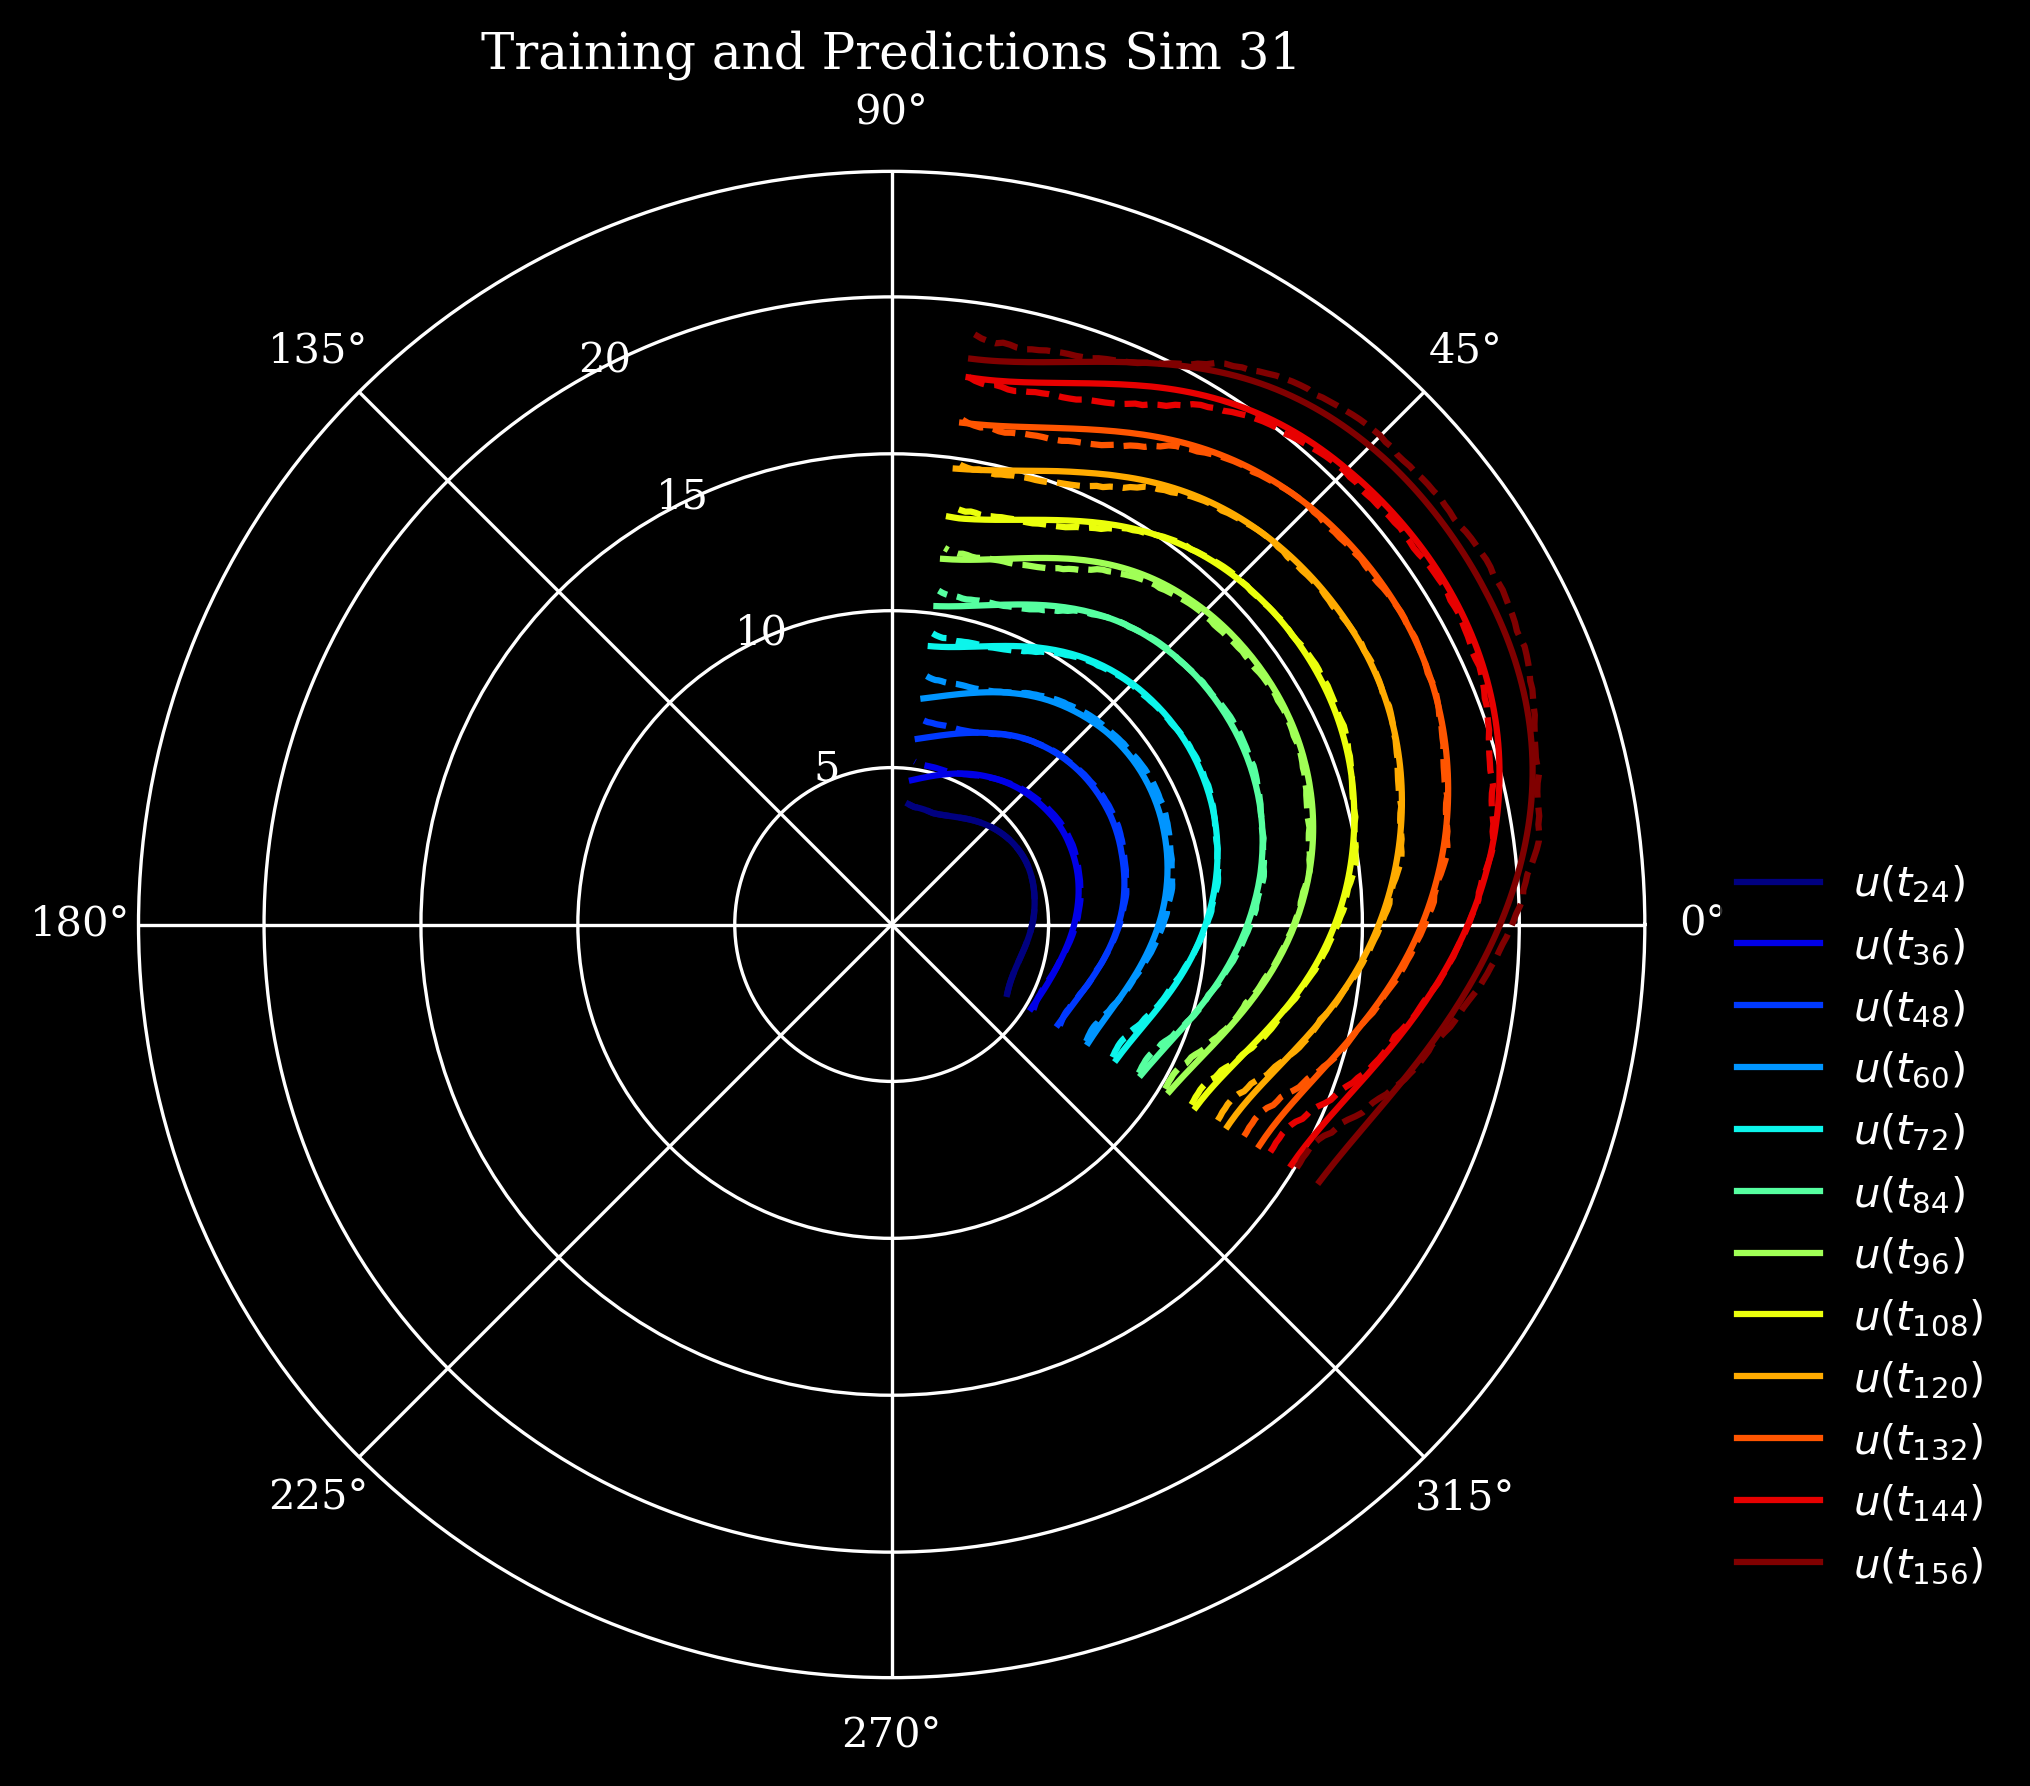

In [75]:
edut.plotTrainPredData1Model(y_full_torch.cpu().numpy()[:, 0, :],
                                 pred_y_full_series.cpu().numpy()[:, 0, :],
                                 ed_2161,
                                 sd_2161,
                                 theta=np.linspace(-31, 82, 160), 
                                 simIdx=0,
                                 savefig=False,
                                 )

Now run model with multiple sims, but keep the usual definition of loss function.

In [ ]:
ii = 0
func = ODEFunc().to(device)
optimizer = optim.Adam(func.parameters(), lr=1e-3)
end = time.time()

niters=6000
test_freq=5

In [ ]:
time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

if runModel:
    # step_loss = []
    for itr in range(1, niters + 1):
        optimizer.zero_grad()
        chosen_sim = np.random.choice(sd_train)
        y0_train_torch, y_train_torch, y_full_torch, t_train_torch, t_scaled_torch, sim_index = getDataForSim(ed_2161,
                                                                                                        augmented_r,
                                                                                                        sd_2161,
                                                                                                        chosen_sim)
        batch_y0, batch_t, batch_y = get_batch(y_train_torch, t_train_torch)
        pred_y = torch.zeros_like(batch_y)

        for i in range(batch_size):
            pred_y[:, i, :, :] = odeint(func, batch_y0[i, :, :], batch_t[i, :]).to(device)

        loss = torch.mean(torch.abs(pred_y - batch_y))
        loss.backward()
        optimizer.step()

        #     step_loss.append(loss.item())

        time_meter.update(time.time() - end)
        loss_meter.update(loss.item())

        if itr % test_freq == 0:
            with torch.no_grad():
                ## more radical defn would be loss on ENTIRE series?
                #             pred_y = odeint(func, y0_train_torch, t_train_torch)
                #             loss = torch.mean(torch.abs(pred_y - y_train_torch))
                pred_y_full_series = odeint(func, y0_train_torch, t_scaled_torch)
                #             print(pred_y_full_series.shape)
                loss_full_series = torch.mean(torch.abs(pred_y_full_series[:, :, :input_dim] 
                                                        - y_full_torch[:, :, :input_dim]))
                print("Iter {:04d} | Total Loss {:.6f} | Sim ID {:03d} ".format(itr,
                                                                                loss_full_series.item(), 
                                                                                chosen_sim))
                ii += 1

        end = time.time()

In [ ]:
# torch.save(func, "dydt_Ay_global_model_5000_steps.pkl")

In [ ]:
# torch.save(optimizer, "dydt_Ay_global_model_optimizer.pkl")

In [ ]:
# func_saved = torch.load("dydt_Ay_global_model_5000_steps.pkl")

In [ ]:
# optim_saved = torch.load("dydt_Ay_global_model_optimizer.pkl")

In [ ]:
# func_saved.eval()

In [ ]:
# optim_saved.state_dict

### Testing for full model

In [ ]:
sd_test

In [ ]:
# y01, yt1, yf1, tt1, ts1, si1 = getDataForSim(ed_2161, augmented_r, sd_2161, 326)

In [ ]:
# si1

In [ ]:
# yf1.shape

In [ ]:
# with torch.no_grad():
#     yt_pred_326 = odeint(func, y01, ts1)

In [ ]:
# yt_pred_326.shape

In [ ]:
# yf1_np = yf1.cpu().numpy()[:, 0, :input_dim]
# yt_pred_np = yt_pred_326.cpu().numpy()[:, 0, :input_dim]

In [ ]:
# edut.plotTrainPredData(yf1_np, 
#                        yt_pred_np, 
#                        ed_2161, 
#                        sd_2161, 
#                        theta=np.linspace(-31, 82, 160),
#                        simIdx=si1, 
#                        savefig=False)

In [ ]:
# edut.plotTrainPredData1Model(yf1_np,
#                              yt_pred_np,
#                              ed_2161,
#                              sd_2161,
#                              theta=np.linspace(-31, 82, 160), 
#                              simIdx=si1,
#                              savefig=False)

In [ ]:
# y02, yt2, yf2, tt2, ts2, si2 = getDataForSim(ed_2161, augmented_r, sd_2161, 70)

In [ ]:
# si2

In [ ]:
# yt2.shape

In [ ]:
# ts2.shape

In [ ]:
# with torch.no_grad():
#     yt_pred_70 = odeint(func, y02, ts2)

In [ ]:
# yf2_np = yf2.cpu().numpy()[:, 0, :input_dim]
# yt_pred2_np = yt_pred_70.cpu().numpy()[:, 0, :input_dim]

In [ ]:
# edut.plotTrainPredData(yf2_np, 
#                        yt_pred2_np, 
#                        ed_2161, 
#                        sd_2161, 
#                        theta=np.linspace(-31, 82, 160),
#                        simIdx=si2, 
#                        savefig=False)

In [ ]:
# edut.plotTrainPredData1Model(yf2_np,
#                              yt_pred2_np,
#                              ed_2161,
#                              sd_2161,
#                              theta=np.linspace(-31, 82, 160), 
#                              simIdx=si2,
#                              savefig=False)

In [ ]:
save_test_preds=False

In [ ]:
if save_test_preds:
    for ss in sd_test:
        y0_test, yt_test, yf_test, tt_test, ts_test, si_test = getDataForSim(ed_2161, augmented_r, sd_2161, ss)

        with torch.no_grad():
            yt_pred_test = odeint(func, y0_test, ts_test)

        y_test_np = yf_test.cpu().numpy()[:, 0, :input_dim]
        y_pred_np = yt_pred_test.cpu().numpy()[:, 0, :input_dim]

        edut.plotTrainPredData1Model(y_test_np,
                                 y_pred_np,
                                 ed_2161,
                                 sd_2161,
                                 theta=np.linspace(-31, 82, 160), 
                                 simIdx=si_test,
                                 savefig=True,
                                 savedir="./test_data_notebook_05_global_model/")

### Test Case with limited Sims

31, 32, 82?

In [ ]:
test_case_sims = np.array([31, 32, 82])

In [ ]:
y0_train_torch_31, y_train_torch_31, y_full_torch_31, t_train_torch_31, t_scaled_torch_31, sim_index_31 = getDataForSim(ed_2161,augmented_r,sd_2161,31)

y0_train_torch_32, y_train_torch_32, y_full_torch_32, t_train_torch_32, t_scaled_torch_32, sim_index_32 = getDataForSim(ed_2161,augmented_r,sd_2161,32)

y0_train_torch_82, y_train_torch_82, y_full_torch_82, t_train_torch_82, t_scaled_torch_82, sim_index_82 = getDataForSim(ed_2161,augmented_r,sd_2161,82)

In [ ]:
y_full_torch_82.shape

In [ ]:
y_full_torch_82.cpu().numpy().shape

In [ ]:
np.expand_dims(np.linspace(-31, 82, 160), axis=1).T.shape

In [ ]:
time_meter_test = RunningAverageMeter(0.97)
loss_meter_test = RunningAverageMeter(0.97)

In [ ]:
sim_iters = 400 # we will train on each individual sim for 400 iterations, and see how the adaptation is working
                # when we move to the next sim. Save test plots for all sims when the 400 iters are complete!

In [ ]:
testCaseSaveDir = "./test_case_adaptation_3sims"

In [ ]:
if runTestCase:
    # step_loss = []
    for each_sim in test_case_sims:
        y0_train_torch, y_train_torch, y_full_torch, t_train_torch, t_scaled_torch, sim_index = getDataForSim(ed_2161,augmented_r,sd_2161,each_sim)
        for itr in range(1, sim_iters + 1):
            optimizer.zero_grad()
            #             chosen_sim = np.random.choice(sd_train)
            batch_y0, batch_t, batch_y = get_batch(y_train_torch, t_train_torch)
            pred_y = torch.zeros_like(batch_y)

            for i in range(batch_size):
                pred_y[:, i, :, :] = odeint(func, batch_y0[i, :, :], batch_t[i, :]).to(device)

            loss = torch.mean(torch.abs(pred_y - batch_y))
            loss.backward()
            optimizer.step()

            #     step_loss.append(loss.item())

            time_meter.update(time.time() - end)
            loss_meter.update(loss.item())

            #             if itr % test_freq == 0:
            with torch.no_grad():

                pred_y_full_series_31 = odeint(func, y0_train_torch_31, t_scaled_torch_31)
                pred_y_full_series_32 = odeint(func, y0_train_torch_32, t_scaled_torch_32)
                pred_y_full_series_82 = odeint(func, y0_train_torch_82, t_scaled_torch_82)
                
                loss1 = torch.mean(torch.abs(pred_y_full_series_31[:, :, :input_dim] - y_full_torch_31[:, :, :input_dim]))
                loss2 = torch.mean(torch.abs(pred_y_full_series_32[:, :, :input_dim] - y_full_torch_32[:, :, :input_dim]))
                loss3 = torch.mean(torch.abs(pred_y_full_series_82[:, :, :input_dim] - y_full_torch_82[:, :, :input_dim]))
                
                print("Iter {:04d} | Total Loss sim 31 sim 32 sim 82 {:.6f} {:.6f} {:.6f} ".format(itr,
                                                                                loss1.item(), 
                                                                                loss2.item(),
                                                                                loss3.item()
                                                                                ))
                if itr == sim_iters:
                    edut.plotTrainPredData1Model(y_full_torch_31.cpu().numpy()[:, 0, :input_dim],
                                 pred_y_full_series_31[:, 0, :input_dim],
                                 ed_2161,
                                 sd_2161,
                                 theta=np.linspace(-31, 82, 160), 
                                 simIdx=sim_index_31,
                                 savefig=True,
                                 savedir=testCaseSaveDir)
                    
                    edut.plotTrainPredData1Model(y_full_torch_32.cpu().numpy()[:, 0, :input_dim],
                                 pred_y_full_series_32[:, 0, :input_dim],
                                 ed_2161,
                                 sd_2161,
                                 theta=np.linspace(-31, 82, 160), 
                                 simIdx=sim_index_32,
                                 savefig=True,
                                 savedir=testCaseSaveDir)
                    
                    edut.plotTrainPredData1Model(y_full_torch_82.cpu().numpy()[:, 0, :input_dim],
                                 pred_y_full_series_82[:, 0, :input_dim],
                                 ed_2161,
                                 sd_2161,
                                 theta=np.linspace(-31, 82, 160), 
                                 simIdx=sim_index_82,
                                 savefig=True,
                                 savedir=testCaseSaveDir)

            end = time.time()